<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span><ul class="toc-item"><li><span><a href="#Решающее-дерево" data-toc-modified-id="Решающее-дерево-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Решающее дерево</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li></ul></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Увеличение-выборки" data-toc-modified-id="Увеличение-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Увеличение выборки</a></span></li><li><span><a href="#Уменьшение-выборки" data-toc-modified-id="Уменьшение-выборки-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Уменьшение выборки</a></span></li><li><span><a href="#Взвешивание-классов" data-toc-modified-id="Взвешивание-классов-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Взвешивание классов</a></span></li><li><span><a href="#Изменение-порога-классификации" data-toc-modified-id="Изменение-порога-классификации-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Изменение порога классификации</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
# !pip install imbalanced-learn==0.8.1
# !pip install optuna -U
# !pip install phik -U

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import os
import pandas as pd
import phik
import re
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.model_selection import (StratifiedKFold, cross_validate,
                                     cross_val_score, train_test_split)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from tqdm import tqdm

In [3]:
def get_df(file_name):
    path_to_file = os.path.relpath(os.path.join('datasets/', file_name))
    if os.path.isfile(path_to_file):
        return pd.read_csv(path_to_file)
    raise Exception('Данные отсутствуют')

In [4]:
df = get_df('Churn.csv')

SEED = 12345

optuna.logging.set_verbosity(optuna.logging.WARNING)
sns.set_style('darkgrid')

In [5]:
df.info()
df.head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


В столбце `Tenure` присутствуют 909 пропусков.
Для восстановления пропущенных значений воспользуемся оригинальным набором данных, указанным в описании проекта.

In [6]:
url = 'https://drive.google.com/uc?id=1minQi8Ymy2i5IbaWU1Szu_j0-dycDj7J'
df_og = pd.read_csv(url)

na_ids = df.loc[df['Tenure'].isna()].index

In [7]:
df.loc[na_ids].drop('Tenure', axis=1).equals(
    df_og.loc[na_ids].drop('Tenure', axis=1)
)

True

In [8]:
df.loc[na_ids, 'Tenure'] = df_og.loc[na_ids, 'Tenure']
df['Tenure'] = df['Tenure'].astype('int64')

In [9]:
df.info()
df.equals(df_og)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


True

Переведём названия столбцов из `CamelCase` в `snake_case`

In [10]:
def camel_to_snake(cols):
    return map(lambda col: re.sub(r'(?<!^)(?=[A-Z])', '_', col).lower(), cols)

In [11]:
df.columns = camel_to_snake(df.columns)
df.sample(5)

,row_number,customer_id,surname,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
2414,2415,15806027,Niu,556,France,Female,52,9,0.00,1,1,0,175149.20,1
4923,4924,15662658,Grieve,651,Germany,Male,34,2,90355.12,2,0,0,193597.94,0
4567,4568,15768530,Emery,554,Spain,Female,27,4,0.00,2,1,1,135083.73,0
8876,8877,15712807,Robertson,556,Spain,Male,46,3,131764.96,1,1,1,108500.66,1
7374,7375,15696287,Converse,682,Germany,Female,38,1,116520.28,1,1,1,49833.50,1


In [12]:
df.describe()

,row_number,customer_id,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


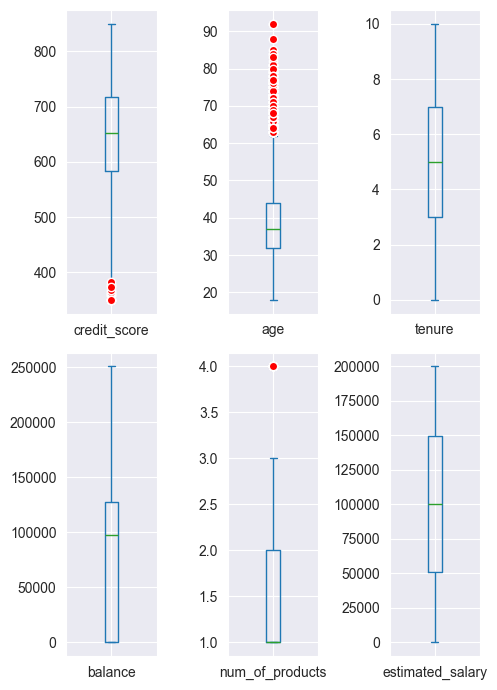

In [13]:
columns = ['credit_score', 'age', 'tenure', 'balance',
           'num_of_products', 'estimated_salary']
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(2, 3, figsize=(5, 7), sharey=False)

for column, ax in zip(columns, axs.flat):
    df[column].plot.box(x=column, ax=ax,
                          flierprops=red_circle)

plt.tight_layout()
plt.show()

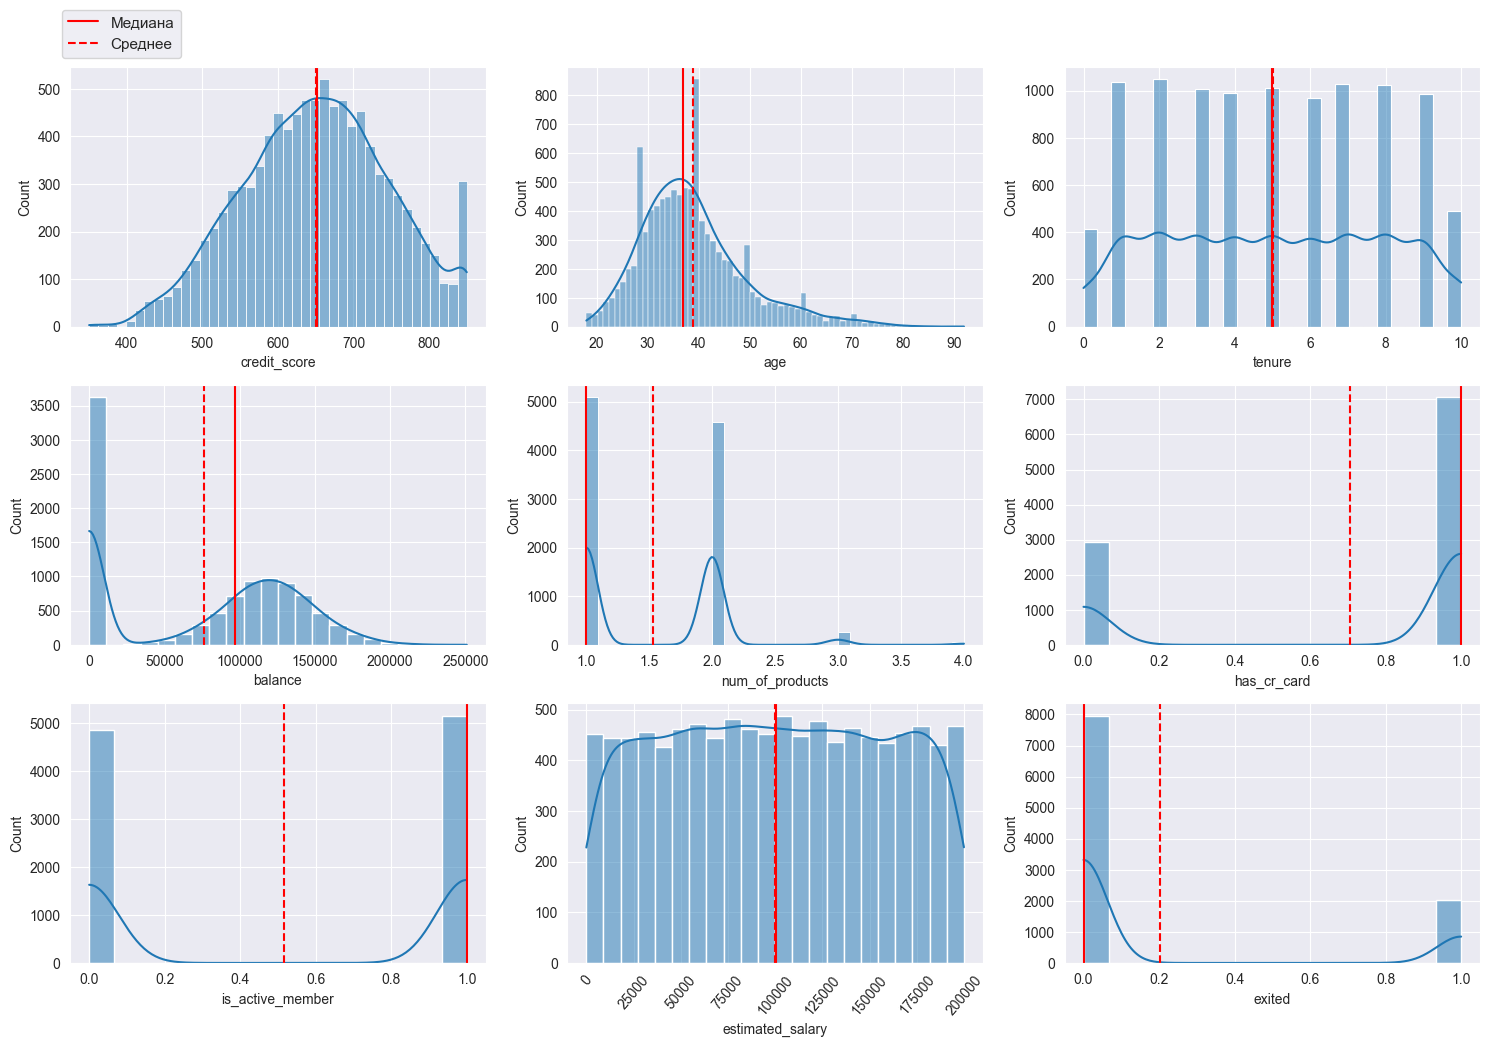

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(15, 10))

columns = df.select_dtypes(include=np.number).columns.tolist()[:1:-1]

i = 0
while columns:
    col = columns.pop()
    mean = df[col].mean()
    median = df[col].median()
    ax = axs[i//12][i%3]
    sns.histplot(df[col], kde=True, ax=ax)
    ax.axvline(x=median, c='r', label=f'Медиана')
    ax.axvline(x=mean, c='r', ls='--', label=f'Среднее')
    if col == 'estimated_salary':
        for label in ax.get_xticklabels():
            label.set(rotation=50, horizontalalignment='center')
    i += 4

plt.tight_layout()
plt.legend(bbox_to_anchor=(-2.11, 3.7), fontsize=11)
plt.show()

В столбце с информацией о предполагаемой зарплате присутствуют аномально низкие значения. Оставляем столбец без изменений, т.к. неизвестно в какой валюте и за какой период указана предполагаемая зарплата (данные были сгенерированы автоматически).

Удалим столбцы, не оказывающие влияния на целевой показатель.

In [15]:
df = df.drop(['row_number', 'customer_id', 'surname'], axis=1)

In [16]:
interval_columns = ['credit_score', 'age', 'tenure',
                    'balance', 'estimated_salary']

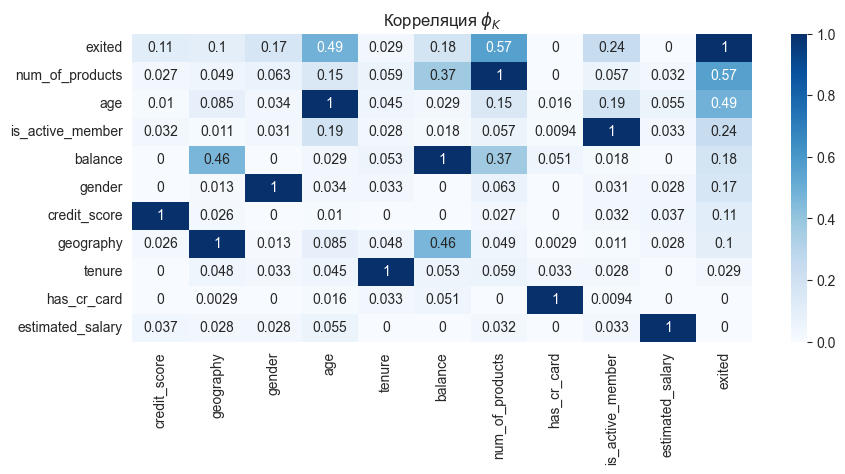

In [17]:
phik_overview = df.phik_matrix(interval_cols=interval_columns)
phik_overview = phik_overview.sort_values(by='exited', ascending=False)

plt.figure(figsize=(10, 4))
sns.heatmap(data=phik_overview, cmap='Blues', annot=True)
plt.title('Корреляция $\phi_K$')
plt.show()

Сильных взаимосвязей между признаками не наблюдается.

**Вывод:**    
- набор данных состоит из 10 тысяч объектов, содержит 8 численных и 6 категориальных переменных;    
- аномальные значения обнаружены только в столбце `estimated_salary`;  
- восстановлены пропуски в колонке `tenure`;  
- удалены переменные, не оказывающие влияния на целевой показатель.

## Исследование задачи

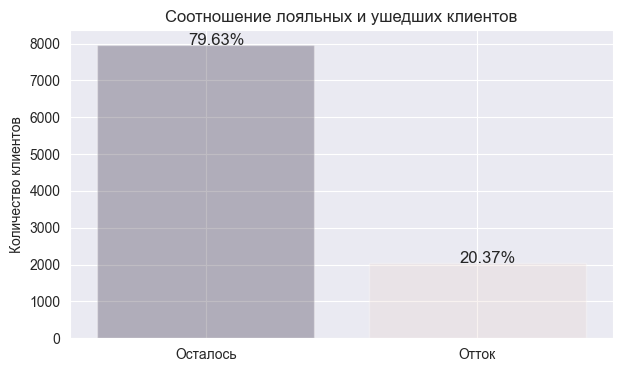

In [18]:
temp = df.pivot_table(index='exited', values='credit_score',
                      aggfunc='count', margins=True)
temp.columns = ['count']
temp['percentage'] = temp.apply(
    lambda x: (x.values / temp.loc['All', 'count'] * 100).round(2)
)
temp = temp.drop('All', axis=0)

plt.figure(figsize=(7, 4))
ax = sns.barplot(data=temp, x=temp.index, y='count',
                 hue='count', dodge=False, alpha=0.3)

patches = ax.patches[1::-1]
for item, value in zip(patches, temp['percentage']):
    plt.annotate(f'{value}%',
                 (item.get_x() + item.get_width() / 2.4, item.get_height()),
                 fontsize=12)

plt.xticks([0, 1], ['Осталось', 'Отток'])
ax.set_xlabel('')
ax.set_ylabel('Количество клиентов')
ax.set_title('Соотношение лояльных и ушедших клиентов')
ax.get_legend().remove()
ax.grid(True)

Классы целевого признака не сбалансированы.  
Соотношение примерно 4:1.

In [19]:
features = df.drop('exited', axis=1)
target = df['exited']

features_train, features_test, target_train, target_test = \
    train_test_split(features, target, test_size=.2,
                     stratify=target, random_state=12345)

print(features_train.shape[0] == target_train.shape[0])
print(features_test.shape[0] == target_test.shape[0])
print(f'Размер обучающей выборки: {features_train.shape[0]}')
print(f'Размер тестовой выборки: {features_test.shape[0]}')
print('Отношение тестовой выборки к обучающей: '
      f'{features_test.shape[0] / features_train.shape[0]:.2f} ')

True
True
Размер обучающей выборки: 8000
Размер тестовой выборки: 2000
Отношение тестовой выборки к обучающей: 0.25 


In [20]:
train_ohe, test_ohe = features_train.copy(), features_test.copy()

cat_features = ['gender', 'geography']

ohe_encoder = OneHotEncoder(drop='first', sparse_output=False)

train_temp = ohe_encoder.fit_transform(train_ohe[cat_features])
train_ohe[ohe_encoder.get_feature_names_out()] = train_temp
train_ohe.drop(cat_features, axis=1, inplace=True)

test_temp = ohe_encoder.transform(test_ohe[cat_features])
test_ohe[ohe_encoder.get_feature_names_out()] = test_temp
test_ohe.drop(cat_features, axis=1, inplace=True)

test_ohe.head()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,gender_Male,geography_Germany,geography_Spain
7837,850,48,2,0.00,1,1,0,169425.30,1.0,0.0,1.0
9505,651,28,10,79562.98,1,1,1,74687.37,1.0,0.0,0.0
6208,714,34,10,0.00,2,1,1,80234.14,1.0,0.0,0.0
5642,782,41,4,0.00,1,1,0,132943.88,0.0,0.0,1.0
9643,521,41,2,0.00,2,1,1,113089.43,0.0,0.0,0.0


In [21]:
def objective(trial, method=None, weight=None, classifier='rf',
              depth=(10, 12), split=(15, 20), features=(2, 4)):
    if classifier == 'rf':
        rf_params = {
            'n_estimators': trial.suggest_int('n_estimators', 20, 100),
            'max_depth': trial.suggest_int('max_depth', *depth),
            'max_features': trial.suggest_int('max_features', *features),
            'min_samples_split': trial.suggest_int('min_samples_split',
                                                   *split)
        }
        clf = RandomForestClassifier(n_jobs=-1, random_state=SEED,
                                     class_weight=weight, **rf_params)
        if method:
            strategy = trial.suggest_float('sampling_strategy',
                                           0.3, 1, step=0.01)
            clf = make_pipeline(
                method(random_state=SEED, sampling_strategy=strategy),
                StandardScaler(), clf
            )
        else:
            clf = make_pipeline(StandardScaler(), clf)

    elif classifier == 'dt':
        dt_params = {
            'max_depth': trial.suggest_int('max_depth', 8, 12),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 9, 14),
            'max_features': trial.suggest_int('max_features', 6, 8)
        }
        clf = DecisionTreeClassifier(random_state=SEED, **dt_params)

    else:
        lr_params = {
            'C': trial.suggest_float('C', 0.6, 0.8),
            'max_iter': trial.suggest_int('max_iter', 100, 3000),
            'solver': trial.suggest_categorical(
                'solver', ['lbfgs', 'liblinear', 'sag', 'saga']
            ),
            'intercept_scaling': trial.suggest_int(
                'intercept_scaling', 50, 70
            ),
            'tol': trial.suggest_float('tol', 0.2, 0.25)
        }
        clf = LogisticRegression(n_jobs=-1, random_state=SEED, **lr_params)
        clf = make_pipeline(StandardScaler(), clf)

    return cross_val_score(
        clf, train_ohe, target_train, scoring='f1', n_jobs=-1,
        cv=StratifiedKFold(5, random_state=SEED, shuffle=True)
    ).mean()

### Решающее дерево

In [22]:
func = lambda trial: objective(trial, classifier='dt')
sampler = optuna.samplers.TPESampler(seed=SEED)
dt_study = optuna.create_study(direction='maximize', sampler=sampler)
dt_study.optimize(func, n_trials=10, show_progress_bar=True)

  0%|          | 0/10 [00:00<?, ?it/s]

In [23]:
clf = DecisionTreeClassifier(random_state=SEED, **dt_study.best_params)
clf = make_pipeline(StandardScaler(), clf)

dt_result = cross_validate(
    clf, train_ohe, target_train, scoring=['f1', 'roc_auc'], n_jobs=-1,
    cv=StratifiedKFold(5, random_state=SEED, shuffle=True)
)


dt_f1 = dt_result['test_f1'].mean()
dt_roc_auc = dt_result['test_roc_auc'].mean()
print(f'F1 = {dt_f1:.3f}\nAUC-ROC = {dt_roc_auc:.3f}')

F1 = 0.567
AUC-ROC = 0.820


### Случайный лес

In [24]:
func = lambda trial: objective(trial, depth=(25, 30), split=(25, 30),
                               features=(6, 9))
sampler = optuna.samplers.TPESampler(seed=SEED)
rf_study = optuna.create_study(direction='maximize', sampler=sampler)
rf_study.optimize(func, n_trials=40, show_progress_bar=True)

  0%|          | 0/40 [00:00<?, ?it/s]

In [25]:
clf = RandomForestClassifier(random_state=SEED, **rf_study.best_params)
clf = make_pipeline(StandardScaler(), clf)

rf_result = cross_validate(
    clf, train_ohe, target_train, scoring=['f1', 'roc_auc'], n_jobs=-1,
    cv=StratifiedKFold(5, random_state=SEED, shuffle=True)
)

rf_f1 = rf_result['test_f1'].mean()
rf_roc_auc = rf_result['test_roc_auc'].mean()
print(f'F1 = {rf_f1:.3f}\nAUC-ROC = {rf_roc_auc:.3f}')

F1 = 0.588
AUC-ROC = 0.847


### Логистическая регрессия

In [26]:
func = lambda trial: objective(trial, classifier='lr')
sampler = optuna.samplers.TPESampler(seed=SEED)
lr_study = optuna.create_study(direction='maximize', sampler=sampler)
lr_study.optimize(func, n_trials=45, show_progress_bar=True)

  0%|          | 0/45 [00:00<?, ?it/s]

In [27]:
clf = LogisticRegression(random_state=SEED, **lr_study.best_params)
clf = make_pipeline(StandardScaler(), clf)

result = cross_validate(
    clf, train_ohe, target_train, scoring=['f1', 'roc_auc'], n_jobs=-1,
    cv=StratifiedKFold(5, random_state=SEED, shuffle=True)
)
lr_f1 = result['test_f1'].mean()
lr_roc_auc = result['test_roc_auc'].mean()
print(f'F1 = {lr_f1:.3f}\nAUC-ROC = {lr_roc_auc:.3f}')

F1 = 0.335
AUC-ROC = 0.762


In [28]:
f1_list = [rf_f1, dt_f1, lr_f1]
roc_auc_list = [rf_roc_auc, dt_roc_auc, lr_roc_auc]

pd.DataFrame(data={'F1-мера': f1_list, 'AUC-ROC': roc_auc_list},
             index=['Случайный лес', 'Решающее дерево', 'Логистическая регрессия'])

,F1-мера,AUC-ROC
Случайный лес,0.587868,0.847257
Решающее дерево,0.567238,0.819892
Логистическая регрессия,0.335386,0.761761


**Вывод:**  
- данные разделены на обучающую и тестовою выборки в соотношении 4:1;
- категориальные признаки преобразованы в численные;  
- выполнен подбор гиперпараметров для моделей решающего дерева,  случайного леса и логистической регрессии;
- лучший результат продемонстрировала модель на основе алгоритма случайного леса.

## Борьба с дисбалансом

### Увеличение выборки

In [29]:
func = lambda trial: objective(trial, SMOTE)
sampler = optuna.samplers.TPESampler(seed=SEED)
up_study = optuna.create_study(direction='maximize', sampler=sampler)
up_study.optimize(func, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
up_f1 = up_study.best_value
up_params = up_study.best_params
strategy = up_params.pop('sampling_strategy')

clf = RandomForestClassifier(random_state=SEED, **up_params, n_jobs=-1)

imba_pipeline = make_pipeline(
    SMOTE(random_state=SEED, sampling_strategy=strategy),
    StandardScaler(), clf
)

up_roc_auc = cross_val_score(
    imba_pipeline, train_ohe, target_train, scoring='roc_auc', n_jobs=-1,
    cv=StratifiedKFold(5, random_state=SEED, shuffle=True)
).mean()
print(f'Upsampling AUC-ROC: {up_roc_auc:.3f}')

Upsampling AUC-ROC: 0.850


### Уменьшение выборки

In [31]:
func = lambda trial: objective(trial, RandomUnderSampler)
sampler = optuna.samplers.TPESampler(seed=SEED)
down_study = optuna.create_study(direction='maximize', sampler=sampler)
down_study.optimize(func, n_trials=75, show_progress_bar=True)

  0%|          | 0/75 [00:00<?, ?it/s]

In [32]:
down_f1 = down_study.best_value
down_params = down_study.best_params
strategy = down_params.pop('sampling_strategy')

clf = RandomForestClassifier(random_state=SEED, **down_params, n_jobs=-1)

imba_pipeline = make_pipeline(
    RandomUnderSampler(random_state=SEED, sampling_strategy=strategy),
    StandardScaler(), clf
)

down_roc_auc = cross_val_score(
    imba_pipeline, train_ohe, target_train, scoring='roc_auc', n_jobs=-1,
    cv=StratifiedKFold(5, random_state=SEED, shuffle=True)
).mean()
print(f'Downsampling AUC-ROC: {down_roc_auc:.3f}')

Downsampling AUC-ROC: 0.856


### Взвешивание классов

In [33]:
func = lambda trial: objective(trial, weight='balanced')
sampler = optuna.samplers.TPESampler(seed=SEED)
balanced_study = optuna.create_study(direction='maximize', sampler=sampler)
balanced_study.optimize(func, n_trials=100, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [34]:
best_params = balanced_study.best_params
balanced_f1 = balanced_study.best_value

clf = RandomForestClassifier(random_state=SEED, class_weight='balanced',
                             **best_params)
best_params = clf.get_params(deep=True)
clf = make_pipeline(StandardScaler(), clf)


balanced_roc_auc = cross_val_score(
        clf, train_ohe, target_train, scoring='roc_auc', n_jobs=-1,
        cv=StratifiedKFold(5, random_state=SEED, shuffle=True)
).mean()
balanced_roc_auc
print(f'Balanced AUC-ROC: {balanced_roc_auc:.3f}')

Balanced AUC-ROC: 0.859


### Изменение порога классификации

In [35]:
best_threshold = None
best_f1_score = 0

for threshold in tqdm(np.arange(0.2, 0.71, 0.05)):
    class LocalClassifier(RandomForestClassifier):

        def predict(self, X):
            return self.predict_proba(X)[:, 1] > threshold

    clf = make_pipeline(StandardScaler(), LocalClassifier(**best_params))

    f1 = cross_val_score(
        clf, train_ohe, target_train, scoring='f1', n_jobs=-1,
        cv=StratifiedKFold(5, random_state=SEED, shuffle=True)
    ).mean()

    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

100%|██████████████████████████████████████████| 11/11 [00:07<00:00,  1.49it/s]


In [36]:
print(f'Порог: {best_threshold:.2f}\nF1-мера: {best_f1_score:.2f}')

Порог: 0.50
F1-мера: 0.62


In [37]:
f1_list = [balanced_f1, down_f1, up_f1]
roc_auc_list = [balanced_roc_auc, down_roc_auc, up_roc_auc]

pd.DataFrame(data={'F1-мера': f1_list, 'AUC-ROC': roc_auc_list},
             index=['Взвешивание классов', 'Уменьшение выборки',
                    'Увеличение выборки'])

,F1-мера,AUC-ROC
Взвешивание классов,0.624327,0.859007
Уменьшение выборки,0.624097,0.855566
Увеличение выборки,0.610793,0.849700


**Вывод:**  
- взвешивание классов и уменьшение выборки дуют наибольший прирост к F1-мере, чуть хуже результат показал метод увеличения выборки;  
- 0.5 – оптимальный порог классификации.

## Тестирование модели

In [38]:
scaler = StandardScaler()

train_ohe = pd.DataFrame(
    scaler.fit_transform(train_ohe), columns=train_ohe.columns,
    index=train_ohe.index
)

test_ohe = pd.DataFrame(
    scaler.transform(test_ohe), columns=test_ohe.columns,
    index=test_ohe.index
)
test_ohe.head(3)

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,gender_Male,geography_Germany,geography_Spain
7837,2.064665,0.872578,-1.047861,-1.224906,-0.911497,0.648814,-1.030464,1.199844,0.911637,-0.578313,1.734942
9505,0.010819,-1.043623,1.727815,0.047190,-0.911497,0.648814,0.970437,-0.446932,0.911637,-0.578313,-0.576388
6208,0.661031,-0.468763,1.727815,-1.224906,0.805878,0.648814,0.970437,-0.350516,0.911637,-0.578313,-0.576388


In [39]:
def plot_roc_curve(roc_auc, threshold=0.5):
    fpr, tpr, thresh = \
        roc_curve(target_test, clf.predict_proba(test_ohe)[:, 1])

    idx = np.argmin(abs(thresh - threshold))
    x_thresh, y_thresh = fpr[idx], tpr[idx]

    plt.figure(figsize=(7, 5))
    
    plt.plot(fpr, tpr, label=f'ROC-кривая (площадь = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], c='r', linestyle='--', label='Случайная модель')

    plt.axhline(y=y_thresh, c='black', ls=':')
    plt.axvline(x=x_thresh, c='black', ls=':')
    
    plt.text(x=.25, y=.6, s=f'Порог : {threshold:.2f}')
    plt.plot(x_thresh, y_thresh, 'ro')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.legend()

In [40]:
clf = RandomForestClassifier(**best_params)

clf.fit(train_ohe, target_train)
f1 = f1_score(target_test, clf.predict(test_ohe))

roc_auc = roc_auc_score(target_test, clf.predict_proba(test_ohe)[:, 1])
print('Показатели на тестовой выборке:')
print(f'  - F1 = {f1:.3f};\n  - AUC-ROC = {roc_auc:.3f}.')

Показатели на тестовой выборке:
  - F1 = 0.630;
  - AUC-ROC = 0.869.


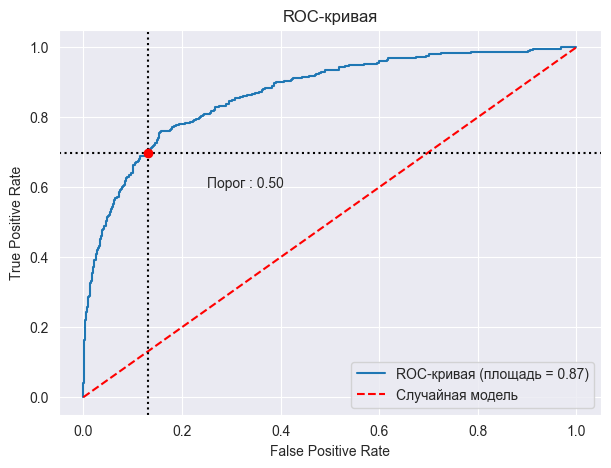

In [41]:
plot_roc_curve(roc_auc)

## Общий вывод

**Описание данных**  
Признаки  
- `row_number` — индекс строки в данных  
- `customer_id` — уникальный идентификатор клиента  
- `surname` — фамилия  
- `credit_score` — кредитный рейтинг  
- `geography` — страна проживания  
- `gender` — пол  
- `age` — возраст  
- `tenure` — сколько лет человек является клиентом банка  
- `balance` — баланс на счёте  
- `num_of_products` — количество продуктов банка, используемых клиентом  
- `has_cr_card` — наличие кредитной карты  
- `is_active_member` — активность клиента  
- `estimated_salary` — предполагаемая зарплата  

Целевой признак  
- `exited` — факт ухода клиента.  

**Подготовка данных:**  
- удалены переменные, не влияющие на целевой признак;   
- восстановлены данные в столбце `tenure`;  
- категориальные признаки преобразованы в численные.  

**Исследование задачи**  
В ходе исследования было выполнено:  
- масштабирование признаков;  
- разделение данных на обучающую и тестовую выборки;  
- сравнение трёх моделей (критерий – *F1*-мера): решающего дерева, случайного леса и логистической регрессии.  

Модель на основе алгоритма случайного леса показала лучшие результаты, поэтому была выбрана для исследования методов увеличения качества при дисбалансе классов.

**Борьба с дисбалансом**  

Было исследовано три метода увеличения качества модели:  
- увеличение выборки;
- уменьшение выборки;
- взвешивание классов.  

С точки зрения метрики *F1* на валидационной выборке методы расположились в следующем порядке:  
1. Взвешивание классов (*F1* = 0.624).  
2. Уменьшение выборки (*F1* = 0.624).  
3. Увеличение выборки (*F1* = 0.611).  